In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings("ignore")


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.optimizers import Adam

import seaborn as sns
import random
import csv

from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler


In [2]:
import numpy as np
import pandas as pd
import pmdarima as pm
from pmdarima import utils
from pmdarima import arima
from pmdarima import model_selection
from tensorflow.keras.layers import LSTM

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from matplotlib import pyplot as plt

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ReLU, PReLU
from keras_tuner.tuners import RandomSearch

from sklearn.metrics import mean_absolute_percentage_error

Using TensorFlow backend


In [4]:
df=pd.read_csv('icecream_sales_date 2009-2022.csv', index_col='date', parse_dates=True,encoding="utf-8")
df.head()

,sales,tokyo_temperature,holiday,Unnamed: 4,temperature_difference_2009_2018,temperature_difference_2019_2021,Unnamed: 7,2009,2010,2011,...,2015,2016,2017,2018,2019,2020,2021,2022,AVERAGE2009-2018,AVERAGE2019-2021
date,,,,,,,,,,,,,,,,,,,,,
2009-01-01,17.59,10.6,1,NaN,0.521429,0.033333,1.0,10.2,11.0,9.1,...,10.4,10.6,10.8,9.4,10.3,11.1,10.3,9.4,10.078571,10.566667
2009-01-02,23.83,11.6,1,NaN,1.521429,1.033333,2.0,11.5,9.9,11.2,...,10.4,12.2,12.1,10.1,11.6,13.3,14.0,10.5,11.142857,12.966667
2009-01-03,22.94,10.7,1,NaN,0.621429,0.133333,3.0,13.7,13.2,12.3,...,15.5,14.9,13.4,16.9,15.4,16.0,17.9,16.6,14.942857,16.433333
2009-01-04,17.14,11.1,1,NaN,1.021429,0.533333,4.0,20.2,16.6,18.9,...,19.3,20.3,19.9,22.1,19.0,18.2,20.6,20.2,19.471429,19.266667
2009-01-05,10.32,11.8,0,NaN,1.721429,1.233333,5.0,23.6,23.0,22.2,...,26.4,25.2,25.1,24.6,25.3,24.0,24.1,23.5,24.242857,24.466667


In [5]:
#df_train=df["2009-01-01":"2018-12-31"]
#df_test=df["2019-01-01":"2019-12-31"]
df_19=df["2009-01-01":"2019-12-31"]

In [6]:
sales=df_19["sales"]
sales

date
2009-01-01    17.59
2009-01-02    23.83
2009-01-03    22.94
2009-01-04    17.14
2009-01-05    10.32
              ...  
2019-12-27    18.54
2019-12-28    24.99
2019-12-29    33.16
2019-12-30    25.73
2019-12-31    33.84
Name: sales, Length: 4015, dtype: float64

In [7]:
sales_train=sales["2009-01-01":"2018-12-31"]
sales_test=sales["2019-01-01":"2019-12-31"]

In [8]:
sales_np = np.array(sales, dtype=float)
sales_np

array([17.59, 23.83, 22.94, ..., 33.16, 25.73, 33.84])

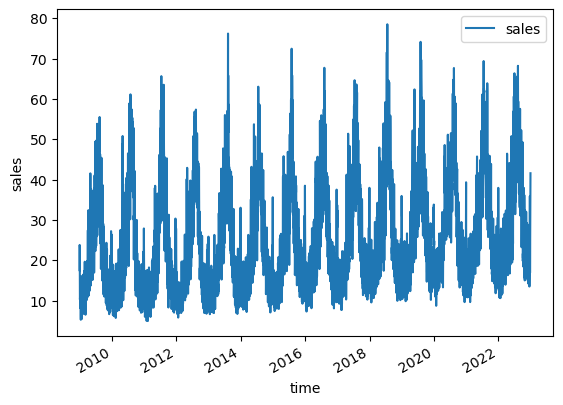

In [32]:
saless=df["sales"]
saless.plot()
#ヨコ軸のラベル
plt.xlabel('time')
plt.ylabel('sales')
plt.legend()                                       #凡例表示
plt.show()

In [10]:
series=sales_np
series.shape

(4015,)

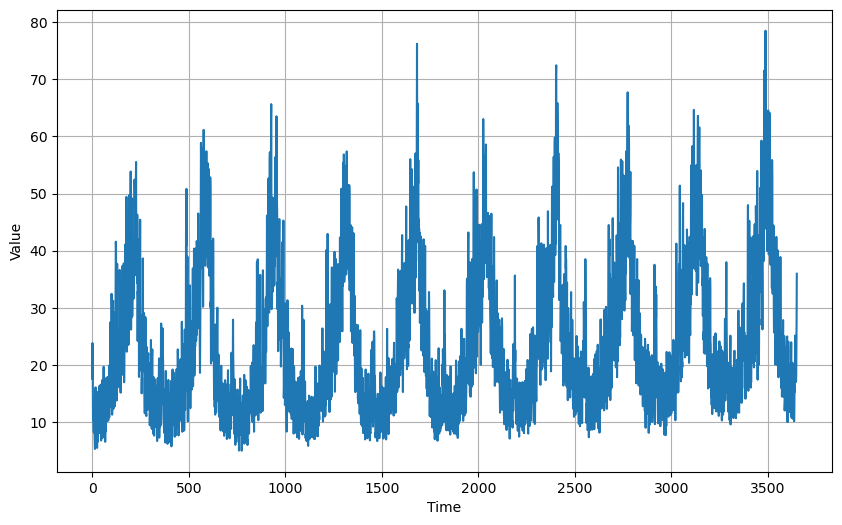

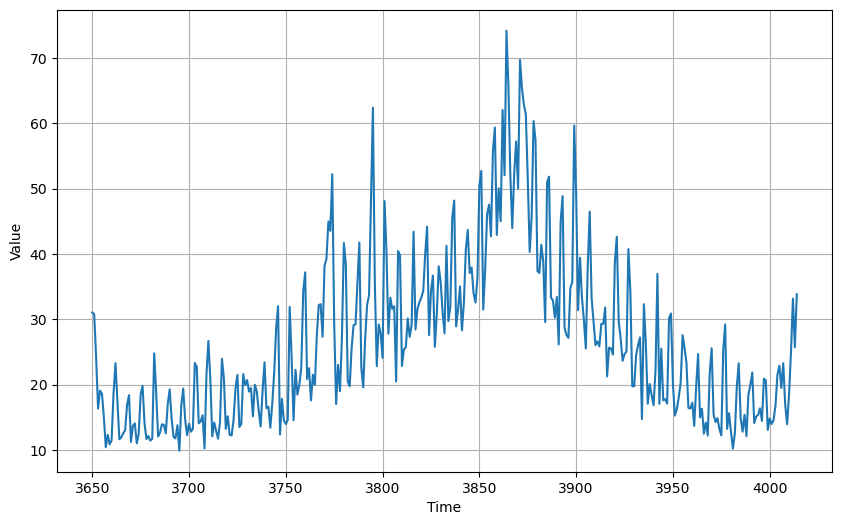

In [11]:
year=10
split_time = 365*year
time = np.arange(365*year+365, dtype="float32")

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]


window_size = 32
batch_size = 256
shuffle_buffer_size = 4000

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

plt.figure(figsize=(10, 6))
plot_series(time_train, x_train) # 学習セット
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid) # 検証セット
plt.show()

In [12]:
def windowing(df, window_size):
  x = []
  y = []

  for i in range(len(df) - window_size):
    x_result = df[i:i+window_size].to_list()
    x.append(x_result)
    y_result = df[i+window_size]
    y.append(y_result)

  return np.array(x), np.array(y)

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [14]:
x_train

array([17.59, 23.83, 22.94, ..., 22.93, 27.97, 35.97])

In [15]:
sales

date
2009-01-01    17.59
2009-01-02    23.83
2009-01-03    22.94
2009-01-04    17.14
2009-01-05    10.32
              ...  
2019-12-27    18.54
2019-12-28    24.99
2019-12-29    33.16
2019-12-30    25.73
2019-12-31    33.84
Name: sales, Length: 4015, dtype: float64

In [16]:
window_size = 20

x_train_lstm, y_train_lstm = windowing(sales_train, window_size)
x_test_lstm, y_test_lstm = windowing(sales_test,window_size)

In [17]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Bidirectional
from tensorflow.keras.layers import Conv1D

# build lstm model
lstm_model = Sequential()
#lstm_model.add(tf.keras.layers.Bidirectional(LSTM(100, input_shape=(window_size, 1))))
#lstm_model.add(Dense(10))
lstm_model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='causal', activation='relu', input_shape=[None, 1]))
lstm_model.add(Bidirectional(LSTM(100, activation='relu', input_shape=(window_size,))))
#lstm_model.add(Bidirectional(LSTM(64, return_sequences=True)))
#lstm_model.add(Bidirectional(LSTM(32)))
#lstm_model.add(Dense(1))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
#lstm_model.add(LSTM(100, input_shape=[window_size, 1], return_sequences=True, dropout=0.1, recurrent_dropout=0.5))
#lstm_model.add(LSTM(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.5, activation='relu')) 
#lstm_model.add(Dense(1))
#lstm_model.summary()

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, 
        verbose=1, mode='auto', restore_best_weights=True)

In [19]:
cp = ModelCheckpoint('model/', save_best_only=True)
lstm_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=RootMeanSquaredError())

In [20]:
# train lstm model
history = lstm_model.fit(tf.expand_dims(x_train_lstm, axis=-1), y_train_lstm, validation_data=(x_test_lstm, y_test_lstm), epochs=50, batch_size=32,verbose=1, callbacks=[cp])

Epoch 1/50
113/114 [============================>.] - ETA: 0s - loss: 124.6801 - root_mean_squared_error: 11.1660

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 8s 49ms/step - loss: 124.2921 - root_mean_squared_error: 11.1486 - val_loss: 50.7747 - val_root_mean_squared_error: 7.1256
Epoch 2/50
113/114 [============================>.] - ETA: 0s - loss: 41.6779 - root_mean_squared_error: 6.4558

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 42ms/step - loss: 41.5960 - root_mean_squared_error: 6.4495 - val_loss: 41.4070 - val_root_mean_squared_error: 6.4348
Epoch 3/50
113/114 [============================>.] - ETA: 0s - loss: 33.8321 - root_mean_squared_error: 5.8165

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 45ms/step - loss: 33.8014 - root_mean_squared_error: 5.8139 - val_loss: 33.4569 - val_root_mean_squared_error: 5.7842
Epoch 4/50
114/114 [==============================] - 2s 16ms/step - loss: 30.6803 - root_mean_squared_error: 5.5390 - val_loss: 34.5037 - val_root_mean_squared_error: 5.8740
Epoch 5/50
112/114 [============================>.] - ETA: 0s - loss: 27.3305 - root_mean_squared_error: 5.2279

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 6s 49ms/step - loss: 27.3664 - root_mean_squared_error: 5.2313 - val_loss: 30.7070 - val_root_mean_squared_error: 5.5414
Epoch 6/50
114/114 [==============================] - 2s 16ms/step - loss: 26.4112 - root_mean_squared_error: 5.1392 - val_loss: 31.6583 - val_root_mean_squared_error: 5.6266
Epoch 7/50
114/114 [==============================] - 2s 16ms/step - loss: 25.3033 - root_mean_squared_error: 5.0302 - val_loss: 31.3574 - val_root_mean_squared_error: 5.5998
Epoch 8/50
111/114 [============================>.] - ETA: 0s - loss: 23.5771 - root_mean_squared_error: 4.8556

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 46ms/step - loss: 23.6196 - root_mean_squared_error: 4.8600 - val_loss: 28.5115 - val_root_mean_squared_error: 5.3396
Epoch 9/50
114/114 [==============================] - 2s 17ms/step - loss: 22.5808 - root_mean_squared_error: 4.7519 - val_loss: 29.2927 - val_root_mean_squared_error: 5.4123
Epoch 10/50
114/114 [==============================] - 2s 18ms/step - loss: 22.2231 - root_mean_squared_error: 4.7141 - val_loss: 31.0591 - val_root_mean_squared_error: 5.5731
Epoch 11/50
114/114 [==============================] - 2s 20ms/step - loss: 22.1684 - root_mean_squared_error: 4.7083 - val_loss: 30.0313 - val_root_mean_squared_error: 5.4801
Epoch 12/50
112/114 [============================>.] - ETA: 0s - loss: 21.6500 - root_mean_squared_error: 4.6530

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 6s 55ms/step - loss: 21.5971 - root_mean_squared_error: 4.6473 - val_loss: 27.0061 - val_root_mean_squared_error: 5.1967
Epoch 13/50
114/114 [==============================] - 2s 18ms/step - loss: 21.4987 - root_mean_squared_error: 4.6367 - val_loss: 27.7593 - val_root_mean_squared_error: 5.2687
Epoch 14/50
114/114 [==============================] - 2s 20ms/step - loss: 21.0208 - root_mean_squared_error: 4.5848 - val_loss: 28.2522 - val_root_mean_squared_error: 5.3153
Epoch 15/50
114/114 [==============================] - 3s 22ms/step - loss: 20.1682 - root_mean_squared_error: 4.4909 - val_loss: 28.5363 - val_root_mean_squared_error: 5.3419
Epoch 16/50
114/114 [==============================] - 3s 22ms/step - loss: 19.9778 - root_mean_squared_error: 4.4697 - val_loss: 29.6898 - val_root_mean_squared_error: 5.4488
Epoch 17/50
114/114 [==============================] - 2s 22ms/step - loss: 20.5963 - root_mean_squared_error: 4.5383 - val_loss: 29

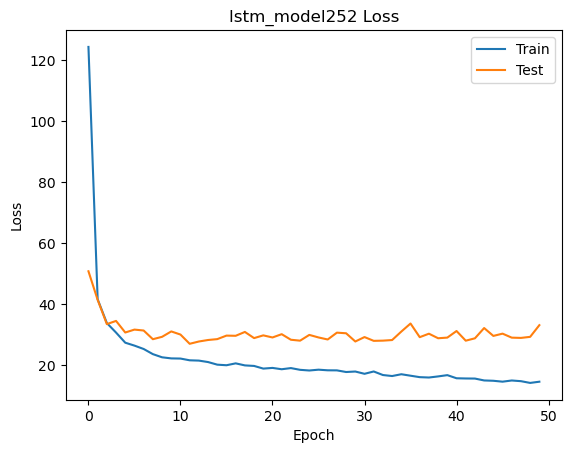

In [21]:
# plot train and test loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('lstm_model252 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

In [22]:
loss_df = pd.DataFrame({'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
loss = pd.DataFrame({'min': loss_df.min(), 'max': loss_df.max()})
loss
print(loss_df.min())

loss        14.184366
val_loss    27.006142
dtype: float64


In [23]:
# load lstm model
from tensorflow.keras.models import load_model
lstm_model = load_model('model/')

In [24]:
train_predictions = lstm_model.predict(x_train_lstm).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train_lstm})
train_results

114/114 [==============================] - 1s 5ms/step


,Train Predictions,Actuals
0,9.785315,7.12
1,8.260977,8.35
2,11.006577,10.68
3,14.770430,14.25
4,13.068975,15.30
...,...,...
3625,15.566483,17.04
3626,16.322710,18.28
3627,24.152182,22.93
3628,25.179970,27.97


In [25]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [26]:
forecast = model_forecast(lstm_model, series[split_time - window_size:-1], window_size)[:,0]

12/12 [==============================] - 1s 105ms/step


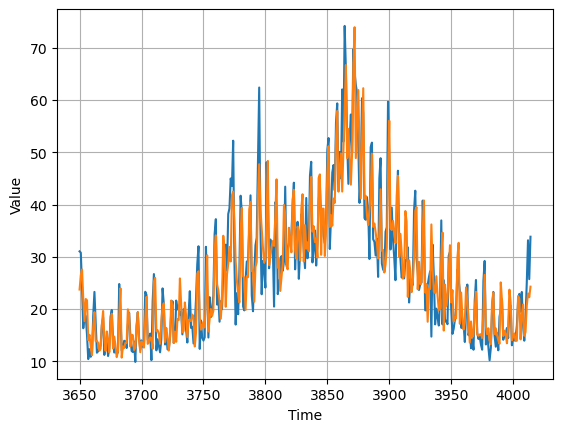

In [27]:
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)

In [28]:
print('RMSE : ',np.sqrt(((x_valid - forecast)**2).mean()))
mae=mean_absolute_error(x_valid, forecast)
print('MAE : ',mae)

RMSE :  5.115956245717061
MAE :  3.8310409854209593


In [29]:
%store forecast

Stored 'forecast' (ndarray)


In [30]:
%store

Stored variables and their in-db values:
forecast             -> array([23.742298 , 26.467682 , 27.575687 , 21.7799
